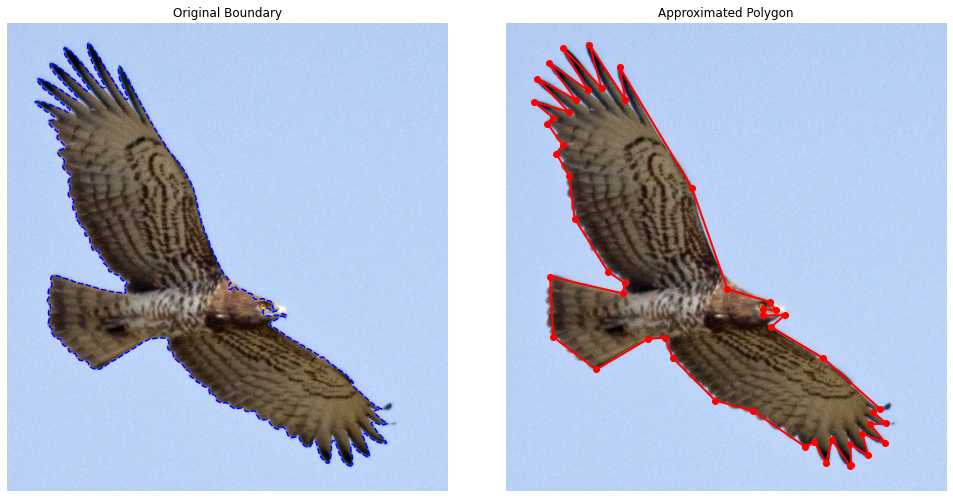

In [26]:
# Polygon approximation by splitting
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, filters, measure, morphology, io

def perpendicular_distance(point, line_start, line_end):
    if np.all(line_start == line_end):
        return np.linalg.norm(point - line_start)
    line = line_end - line_start
    t = np.dot(point - line_start, line) / np.dot(line, line)
    t = np.clip(t, 0, 1)
    projection = line_start + t * line
    return np.linalg.norm(point - projection)

def split_polygon(points, start_idx, end_idx, threshold, result):
    start_point = points[start_idx]
    end_point = points[end_idx]
    max_distance = -1
    index_of_max = -1
    for i in range(start_idx + 1, end_idx):
        dist = perpendicular_distance(points[i], start_point, end_point)
        if dist > max_distance:
            max_distance = dist
            index_of_max = i
    if max_distance > threshold:
        split_polygon(points, start_idx, index_of_max, threshold, result)
        split_polygon(points, index_of_max, end_idx, threshold, result)
    else:
        result.append(end_idx)

def polygon_approximation_with_splitting(boundary_points, threshold):
    result = [0]
    split_polygon(boundary_points, 0, len(boundary_points) - 1, threshold, result)
    return boundary_points[result]

image_rgb = io.imread("20.jpg")  
image_rgb = image_rgb[500:1350, 600:1400]
# Convert to grayscale
gray = color.rgb2gray(image_rgb)

# Apply thresholding (Otsu)
thresh = filters.threshold_otsu(gray)
binary = gray < thresh  # Invert if needed depending on your object

# Clean mask
binary = morphology.remove_small_objects(binary, min_size=500)
binary = morphology.binary_closing(binary, morphology.disk(3))
binary = morphology.remove_small_holes(binary, area_threshold=1000)

# Find contours
contours = measure.find_contours(binary, 0.5)
contour = max(contours, key=len)  # largest one

# Downsample for speed
contour = contour[::5]

# Polygon approximation
threshold = 10.0
approx_polygon = polygon_approximation_with_splitting(contour, threshold)

# Plot original and approximated contours separately
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Original Boundary Visualization
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.plot(contour[:, 1], contour[:, 0], linestyle='--', color='blue', linewidth=1.5)
plt.title("Original Boundary")
plt.axis('off')

# Approximated Polygon Visualization
plt.subplot(1, 2, 2)
plt.imshow(image_rgb)
plt.plot([p[1] for p in approx_polygon], [p[0] for p in approx_polygon], 'ro-', linewidth=2)
plt.title("Approximated Polygon")
plt.axis('off')

plt.tight_layout()
plt.show()


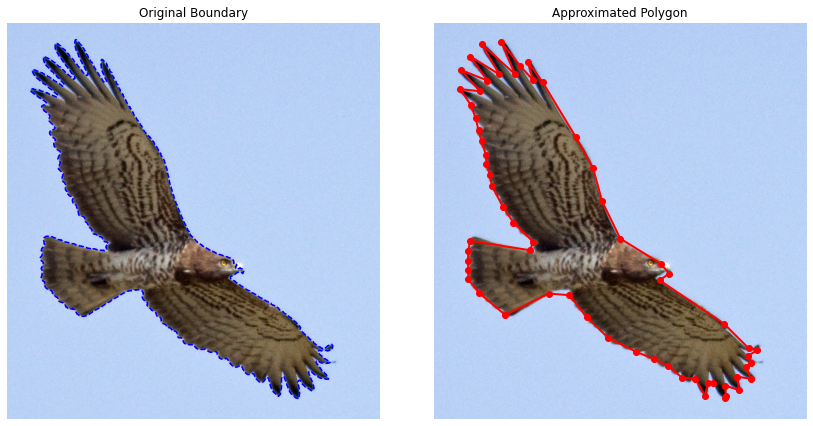

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure, morphology, io
from sklearn.linear_model import LinearRegression

def least_squares_error(P):
    """ Compute Least Squares Error for the set of points P fitting a line. """
    # Prepare points (x, y)
    X = np.array([p[1] for p in P]).reshape(-1, 1)
    Y = np.array([p[0] for p in P])
    
    # Fit linear regression (a line) to the points
    model = LinearRegression()
    model.fit(X, Y)
    
    # The parameters of the line
    a = model.coef_[0]
    b = model.intercept_
    
    # Predict the y values using the line
    Y_pred = model.predict(X)
    
    # Calculate the Least Squares Error (sum of squared errors)
    L = np.sum((Y - Y_pred) ** 2)
    
    return a, b, L

def polygon_approximation_by_merging(boundary_points, threshold):
    P = [boundary_points[0]]  # Start with the first point
    vertices = []  # Store the vertices
    for i in range(1, len(boundary_points)):
        P.append(boundary_points[i])
        a, b, L = least_squares_error(P)
        
        # If the error is above threshold, add the last point as a vertex
        if L >= threshold:
            vertices.append(P[-2])  # Last pixel before the break
            P = [boundary_points[i]]  # Start new subset
    
    # Add the last point to the vertices
    vertices.append(P[-1])
    return vertices

# === MAIN PIPELINE ===
# Load the horse image
image_rgb = io.imread("20.jpg")  # Replace with your local image path if needed
image_rgb = image_rgb[500:1350, 600:1400]

# Convert to grayscale
gray = image_rgb.mean(axis=2)  # Simple grayscale conversion

# Apply thresholding (Otsu or simple thresholding)
thresh = gray.mean()  # Simple thresholding; you could use filters.threshold_otsu()
binary = gray < thresh  # Invert if needed depending on your object

# Clean mask (optional)
binary = morphology.remove_small_objects(binary, min_size=500)
binary = morphology.binary_closing(binary, morphology.disk(3))
binary = morphology.remove_small_holes(binary, area_threshold=1000)

# Find contours
contours = measure.find_contours(binary, 0.5)
contour = max(contours, key=len)  # largest contour

# Polygon approximation
threshold = 1000.0  # Adjust this threshold to control the "tightness" of the polygon
approx_polygon = polygon_approximation_by_merging(contour, threshold)

# Plot the original contour and the approximated polygon separately
plt.figure(figsize=(12, 6))

# Original Boundary Visualization
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.plot(contour[:, 1], contour[:, 0], linestyle='--', color='blue', linewidth=1.5)
plt.title("Original Boundary")
plt.axis('off')

# Approximated Polygon Visualization
plt.subplot(1, 2, 2)
plt.imshow(image_rgb)
plt.plot([p[1] for p in approx_polygon], [p[0] for p in approx_polygon], 'ro-', linewidth=2)
plt.title("Approximated Polygon")
plt.axis('off')

plt.tight_layout()
plt.show()
